## Kaggle - Titanic Problem

In [218]:
# importing libraries
import os
import os.path as op
import shutil
import warnings
import zipfile
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yaml

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold

pd.set_option("display.max_columns",200)
pd.set_option("display.max_rows",200)
warnings.filterwarnings("ignore")
SEED = 0

### Loading Dataset

In [3]:
# function to read the config file
def read_yaml(file_path):
    with open(file_path,"r") as yaml_file:
        config = yaml.safe_load(yaml_file)
    return config

# reading config file
config_path = Path().resolve() / "conf" / "config.yaml"
config = read_yaml(config_path)

# define paths
datasets = config["datasets"]
download_path = str(Path("..") / datasets["abs_path"])
train_path = Path("..") / datasets["train"]
test_path = Path("..") / datasets["test"]
raw_path = Path("..") / datasets["raw"]
# processed_path = Path("..") / datasets["processed"]
# cleaned_path = Path("..") / datasets["cleaned"]

# decide whether to overwrite the existing file or not
overwrite = datasets["overwrite"]


In [19]:
# download data
os.makedirs(download_path,exist_ok=True)
!kaggle competitions download -c titanic -p $download_path

# making directory if the directory doesn't exist for the data
os.makedirs(raw_path,exist_ok=True)
os.makedirs(train_path,exist_ok=True)
os.makedirs(test_path,exist_ok=True)

# extracting the zip file
with zipfile.ZipFile(Path(download_path) / "titanic.zip", "r") as zip_ref:
    zip_ref.extractall(raw_path)

# Construct source file paths
train_source_path = op.join(raw_path, "train.csv")
test_source_path = op.join(raw_path, "test.csv")

# Check if the destination file already exists
if op.exists(op.join(train_path, "train.csv")):
    if overwrite:
        # Remove the existing file
        os.remove(op.join(train_path, "train.csv"))
        # Move train.csv to train_path, overwriting the existing file
        shutil.move(train_source_path, train_path)
    else:
        # Remove the new file
        os.remove(train_source_path)
        # Handle the case where the file should not be overwritten
        print("Destination file already exists and overwrite is set to False. File not moved.")

if op.exists(op.join(test_path, "test.csv")):
    if overwrite:
        # Remove the existing file
        os.remove(op.join(test_path, "test.csv"))
        # Move train.csv to train_path, overwriting the existing file
        shutil.move(test_source_path, test_path)
    else:
        # Remove the existing file
        os.remove(test_source_path)
        # Handle the case where the file should not be overwritten
        print("Destination file already exists and overwrite is set to False. File not moved.")
else:
    # Move train.csv to train_path
    shutil.move(train_source_path, train_path)
    # Move test.csv to test_path
    shutil.move(test_source_path, test_path)

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [75]:
# Exploring the data
df_train = pd.read_csv(op.join(train_path,"train.csv"))
df_train.columns = ["_".join(list(map(str.strip, i.strip().split()))).lower().strip() for i in df_train.columns]
df_test = pd.read_csv(op.join(test_path,"test.csv"))
df_test.columns = ["_".join(list(map(str.strip, i.strip().split()))).lower().strip() for i in df_test.columns]
df_concat = pd.concat([df_train,df_test],sort=True).reset_index(drop=True)
df_concat.columns = ["_".join(list(map(str.strip, i.strip().split()))).lower().strip() for i in df_concat.columns]

print(f"The shape of train data: {df_train.shape}")
print(f"Columns in train data: {list(df_train.columns)}")

print(f"\nThe shape of test data: {df_test.shape}")
print(f"Columns in test data: {list(df_test.columns)}")

# identifying the numeric and categoric variables
numeric_variables = df_concat.select_dtypes(include=['number']).columns
categorical_variables = df_concat.select_dtypes(include=['object']).columns
print(f"\nThe numeric columns are: {list(numeric_variables)}")
print(f"The categorical columns are: {list(categorical_variables)}")


The shape of train data: (891, 12)
Columns in train data: ['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked']

The shape of test data: (418, 11)
Columns in test data: ['passengerid', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked']

The numeric columns are: ['age', 'fare', 'parch', 'passengerid', 'pclass', 'sibsp', 'survived']
The categorical columns are: ['cabin', 'embarked', 'name', 'sex', 'ticket']


- The data is split into Test and Train data sets
- The Training data set has a shape: (891,12)
- The Testing data set has a shape: (418,11)
- 'Survived' is the target variable; this is the extra feature in training set.

### Exploring the data

#### Helper functions

In [76]:
# returns each column and the number of unique values present in it
def display_uniqueness_in_features(df):
    message = "\nUnique Values in Each Column:\n"
    for col in df.columns:
        message += f"{col.capitalize()}: {df[col].nunique()}\n"
    return message

# returns each column and the number of missing values in the column
def missing_data(df):
    message = "\nMissing Values in Each Column:\n"
    for col in df.columns:
        missing_val = df[col].isnull().sum()
        if missing_val > 0:
            message += f"{col.capitalize()}: {missing_val}\n"
    return message

# returns each column and the percentage of missing values in the column
def percent_missing_data(df, size):
    message = "\nPercentage of Missing Values in Each Column:\n"
    for col in df.columns:
        missing_val = df[col].isnull().sum()
        if missing_val > 0:
            percent_missing = (100 * (missing_val / size)).round(2)
            message += f"{col.capitalize()}: {percent_missing}%\n"
    return message

# function to plot histogram for univariate analysis
def plot_histogram(data, col, hue=None):
    plt.figure(figsize=(10, 6))
    if hue:
        sns.histplot(data=data, x=col, hue=hue, kde=True, palette="husl", edgecolor="black")
        plt.title(f"Histogram of {col.capitalize()} by {hue.capitalize()}", fontsize=16)
    else:
        sns.histplot(data[col], bins=20, kde=True, color="lightseagreen", edgecolor="black")
        plt.title(f"Histogram of {col.capitalize()} Column", fontsize=16)
    plt.xlabel(f"{col.capitalize()}", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

# function to plot box plot for univariate and bivariate analysis
def plot_box_plot(data, col, hue=None):
    plt.figure(figsize=(10, 6))
    if hue:
        sns.boxplot(data=data, x=col, y=hue, palette="husl")
        plt.title(f"Box Plot of {col.capitalize()} by {hue.capitalize()}", fontsize=16)
        plt.xlabel(f"{col.capitalize()}", fontsize=14)
        plt.ylabel(f"{hue.capitalize()}", fontsize=14)
    else:
        sns.boxplot(data=data, x=col, color="lightseagreen")
        plt.title(f"Box Plot of {col.capitalize()} Column", fontsize=16)
        plt.xlabel(f"{col.capitalize()}", fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

# function to get descriptive statistics and visualizations
def analyze_column(data, col):
    # descriptive statistics
    print("\nDescriptive Statistics of", col.capitalize(), "Column:")
    print(data[col].describe().to_string())
    
    # calculate z-scores for outlier detection
    z_scores = (data[col] - data[col].mean()) / data[col].std()
    extreme_values = data[np.abs(z_scores) > 3]  # Extreme outliers (z-score > 3 or < -3)
    
    # display extreme values
    if not extreme_values.empty:
        print("\nExtreme Values (Z-Score > 3 or < -3):")
        print(extreme_values.to_string(index=False))
    
    # skewness and kurtosis
    skewness = data[col].skew()
    kurtosis = data[col].kurtosis()
    print("\nSkewness of", col.capitalize(), "Column:", skewness)
    print("Kurtosis of", col.capitalize(), "Column:", kurtosis)
    
    # visualizations
    plot_histogram(data, col)
    plot_box_plot(data, col)

# function to get correlation table for a specific feature
def get_correlation_table(data, threshold=0, feature=None):
    # calculate correlation matrix
    correlation_matrix = data.corr().abs()

    # unstack correlation matrix, sort values, and reset index
    correlation_table = correlation_matrix.unstack().sort_values(ascending=False).reset_index()
    
    # rename columns for clarity
    correlation_table = correlation_table.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation Coefficient"})
    correlation_table = correlation_table[(correlation_table["Feature 1"]!=correlation_table["Feature 2"])]
    correlation_table = correlation_table[~correlation_table["Correlation Coefficient"].isna()]
    correlation_table["Correlation Coefficient"] = correlation_table["Correlation Coefficient"].astype(float)
    correlation_table = correlation_table[correlation_table["Correlation Coefficient"]>=threshold]

    # filter correlation table for the specified feature
    if feature==None:
        return correlation_table.reset_index(drop=True).round(3)
    correlation_table = correlation_table[correlation_table["Feature 1"] == feature].reset_index(drop=True).round(3)
    return correlation_table

def bivariate_analysis_age_categorical(data, age_col, categorical_cols):
    for col in categorical_cols:
        # Summary statistics by category
        print(f"\nSummary Statistics for {age_col.capitalize()} by {col.capitalize()}:")
        print(data.groupby(col)[age_col].describe())

        # Conduct t-test to compare mean ages between different categories
        t_statistic, p_value = stats.ttest_ind(data[data[col] == data[col].unique()[0]][age_col].dropna(),
                                                data[data[col] == data[col].unique()[1]][age_col].dropna())
        print("\nT-Statistic:", t_statistic.round(3))
        print("P-Value:", p_value.round(3))

        # Calculate point-biserial correlation coefficient
        point_biserial_corr = data[age_col].corr(data[col].astype('category').cat.codes).round(3)
        print("Point-Biserial Correlation Coefficient between Age and", col.capitalize() + ":", point_biserial_corr)

        # Plot histogram and box plot
        plot_histogram(data, age_col, hue=col)
        plot_box_plot(data, age_col, hue=col)

def analyze_deck(data,deck):
    deck_filter = data[data["deck"]==deck]
    non_null_survival = data[~data["survived"].isna()]
    deck_nonna = non_null_survival[non_null_survival["deck"]==deck]
    survival_rate = ((deck_nonna[deck_nonna["survived"]==1]["deck"].count()/deck_nonna.shape[0])*100).round()
    message = f"Deck: {deck}\nMedian Fare: {deck_filter.fare.median().round(2)}\nMedian Age: {deck_filter.age.median().round(2)}\nMedian Class: {deck_filter.pclass.median().round(2)}\nSurvival Rate: {survival_rate}\n"
    return message

#### Overview

In [77]:
display(df_train.sample(3))
print("Training data set information:")
display(df_train.info())

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
585,586,1,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.6500,E68,S
833,834,0,3,"Augustsson, Mr. Albert",male,23.0,0,0,347468,7.8542,NaN,S
514,515,0,3,"Coleff, Mr. Satio",male,24.0,0,0,349209,7.4958,NaN,S


Training data set information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

In [78]:
display(df_test.sample(3))
print("Testing data set information:")
display(df_test.info())

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
228,1120,3,"Everett, Mr. Thomas James",male,40.5,0,0,C.A. 6212,15.10,NaN,S
396,1288,3,"Colbert, Mr. Patrick",male,24.0,0,0,371109,7.25,NaN,Q
313,1205,3,"Carr, Miss. Jeannie",female,37.0,0,0,368364,7.75,NaN,Q


Testing data set information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  418 non-null    int64  
 1   pclass       418 non-null    int64  
 2   name         418 non-null    object 
 3   sex          418 non-null    object 
 4   age          332 non-null    float64
 5   sibsp        418 non-null    int64  
 6   parch        418 non-null    int64  
 7   ticket       418 non-null    object 
 8   fare         417 non-null    float64
 9   cabin        91 non-null     object 
 10  embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

#### Uniqueness in Features

In [79]:
# checking uniqueness in the features of train and test sets
uniqueness_in_trainset = display_uniqueness_in_features(df_train)
uniqueness_in_testset = display_uniqueness_in_features(df_test)
print("Training set",uniqueness_in_trainset,sep="\n")
print("\nTesting set",uniqueness_in_testset,sep="\n")

Training set

Unique Values in Each Column:
Passengerid: 891
Survived: 2
Pclass: 3
Name: 891
Sex: 2
Age: 88
Sibsp: 7
Parch: 7
Ticket: 681
Fare: 248
Cabin: 147
Embarked: 3


Testing set

Unique Values in Each Column:
Passengerid: 418
Pclass: 3
Name: 418
Sex: 2
Age: 79
Sibsp: 7
Parch: 8
Ticket: 363
Fare: 169
Cabin: 76
Embarked: 3



#### Missing Values

In [80]:
# uniqueness in a column gives the predictive power of that column
# checking the columns if the distinctiveness in columns is not due to missing values
missing_data_in_trainset = missing_data(df_train)
missing_data_in_testset = missing_data(df_test)
print("Training set",missing_data_in_trainset,sep="\n")
print("\nTesting set",missing_data_in_testset,sep="\n")

Training set

Missing Values in Each Column:
Age: 177
Cabin: 687
Embarked: 2


Testing set

Missing Values in Each Column:
Age: 86
Fare: 1
Cabin: 327



- The columns in Training data with missing values: ```Age```,```Embarked```,```Cabin```
- The columns in Testing data with missing values: ```Age```,```Fare```,```Cabin```
- Now it is clear that ```PassengerId``` and ```Name``` doesn't really affect the target variable.

In [81]:
# calculating the % of missing values in the columns
missing_percent_train = percent_missing_data(df_train,df_train.shape[0])
missing_percent_test = percent_missing_data(df_test,df_test.shape[0])
print("Training set",missing_percent_train,sep="\n")
print("\nTesting set",missing_percent_test,sep="\n")

Training set

Percentage of Missing Values in Each Column:
Age: 19.87%
Cabin: 77.1%
Embarked: 0.22%


Testing set

Percentage of Missing Values in Each Column:
Age: 20.57%
Fare: 0.24%
Cabin: 78.23%



In [82]:
# let's work on concatenated data set to fill missing value to avoid overfitting of data
missing_percent_concatenated = percent_missing_data(df_concat.drop("survived",axis=1),df_concat.shape[0])
print("Concatenated Data set",missing_percent_concatenated,sep="\n")

Concatenated Data set

Percentage of Missing Values in Each Column:
Age: 20.09%
Cabin: 77.46%
Embarked: 0.15%
Fare: 0.08%



- Upon closer inspection,
    - The % of data missing in Columns ```Age```,```Fare```,```Embarked``` are very small.
    - These columns can be filled with descriptive statistics measures.
    - To avoid potential bias and uncertainity, the same cannot be suitable for ```Cabin```

##### Fare

In [83]:
# missing fare data
missing_fare = df_concat[df_concat["fare"].isnull()].reset_index(drop=True)
missing_fare

,age,cabin,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket
0,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


- There is only one passenger with missing ```Fare``` value.
- Here, ```Fare``` can be assumed to be dependent on the Class and Family size.

In [84]:
fpclass,fparch,fsibsp = missing_fare["pclass"].loc[0],missing_fare["parch"].loc[0],missing_fare["sibsp"].loc[0]
median_fare = df_concat.groupby(["pclass","parch","sibsp"]).fare.median()[fpclass][fparch][fsibsp]
df_concat["fare"] = df_concat["fare"].fillna(median_fare)

##### Embarked

In [85]:
# missing embarked data
missing_embark = df_concat[df_concat["embarked"].isnull()].reset_index(drop=True)
missing_embark

,age,cabin,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket
0,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
1,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


- Only two passengers are missing the ```Embarked``` information.
- Both the passengers are Female, from Upper class.

In [86]:
# finding the mode of the 'Embarked' variable based on Pclass and Sex.
embark_mode = df_concat.groupby(["pclass","sex"])["embarked"].describe()
embark_mode

count unique top freq
pclass sex                         
1      female   142      3   C   71
       male     179      3   S  108
2      female   106      3   S   93
       male     171      3   S  149
3      female   216      3   S  129
       male     493      3   S  366

- Based on the mode we calculated above, the passengers must have been Embarked at C (Cherbourg).
- But with online research, the passenger "Martha Evelyn" boarded at S (Southampton) with her maid "Amelie Icard".
- For the source: Click_here[https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html]

In [87]:
# filling missing value as "S"
df_concat["embarked"] = df_concat["embarked"].fillna("S")

##### Age


Descriptive Statistics of Age Column:
count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000

Extreme Values (Z-Score > 3 or < -3):
 age cabin embarked   fare                                                   name  parch  passengerid  pclass    sex  sibsp  survived ticket
80.0   A23        S 30.000                   Barkworth, Mr. Algernon Henry Wilson      0          631       1   male      0       1.0  27042
74.0   NaN        S  7.775                                    Svensson, Mr. Johan      0          852       3   male      0       0.0 347060
76.0   C46        S 78.850 Cavendish, Mrs. Tyrell William (Julia Florence Siegel)      0          988       1 female      1       NaN  19877

Skewness of Age Column: 0.40767455974362266
Kurtosis of Age Column: 0.1469476357378139


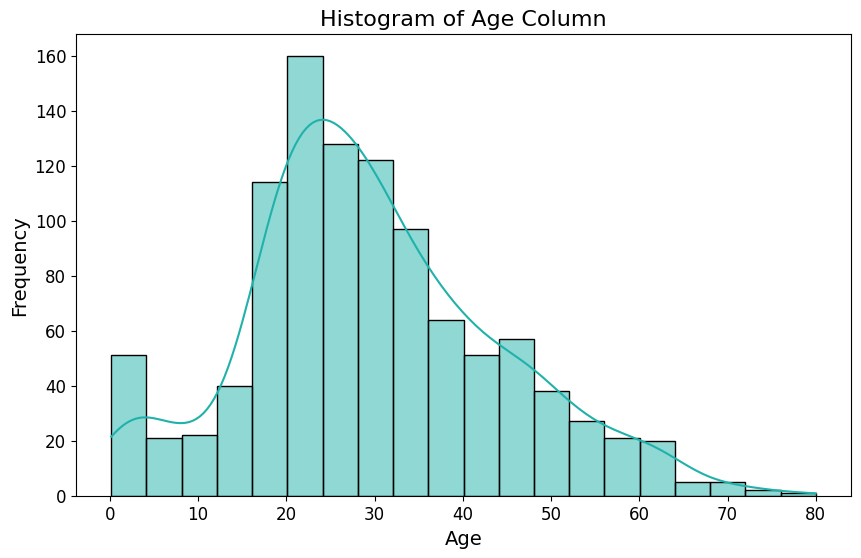

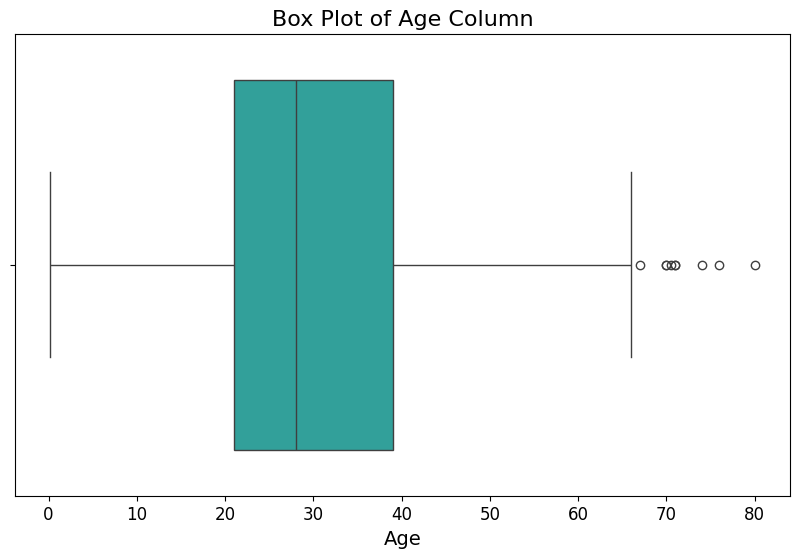

In [88]:
# univariate analysis on the "Age" column
analyze_column(df_concat, "age")

- Based on the distribution, and skewness; we can choose median as the descriptive measure to fill the missing values.
- Let's conduct bivariate analysis on ```Age```, as there are outliers present in this column, and this factor can induce bias or uncertainity.

In [89]:
# bivariate analysis on age column - with numeric columns
age_correlation = get_correlation_table(df_concat[numeric_variables],feature="age")
survived_correlation = get_correlation_table(df_concat[numeric_variables],feature="survived")
print("Correlation Table for 'Age':")
display(age_correlation)
print("Correlation Table for 'Survived':")
display(survived_correlation)

Correlation Table for 'Age':


,Feature 1,Feature 2,Correlation Coefficient
0,age,pclass,0.408
1,age,sibsp,0.244
2,age,fare,0.177
3,age,parch,0.151
4,age,survived,0.077
5,age,passengerid,0.029


Correlation Table for 'Survived':


,Feature 1,Feature 2,Correlation Coefficient
0,survived,pclass,0.338
1,survived,fare,0.257
2,survived,parch,0.082
3,survived,age,0.077
4,survived,sibsp,0.035
5,survived,passengerid,0.005


- ```Age``` is highly correlated with ```Pclass``` .i.e., ```0.408```, while ```Survived``` (Target) is highly correlated with ```Pclass``` .i.e., ```0.408```.
- We can consider that median age ```Pclass``` groups is suited to fill the missing values due to its correlation with ```Age``` and ```Survived```.
- Let's also do bivariate analysis of ```Age``` and categorical variables as those were excluded in the above analysis.

- For bivarivate analysis between ```Age``` and catagorical variable, we are excluding:
    - Cabin and Embarked (as these variables themselves are unrealiable due to missing data)
    - Ticket and Name (due to uniqueness of the variables, these may induce bias)

- Hypothesis: 
    - Assuming the significance level, $$\alpha = 0.05$$
    - Null Hypothesis: There is no difference between the mean ages of males and females. $$\mu_{males} = \mu_{females}$$
    - Alternative Hypothesis: There is a difference between the mean ages of males and females.$$\mu_{males} \neq \mu_{females}$$


Summary Statistics for Age by Sex:
        count       mean        std   min   25%   50%   75%   max
sex                                                              
female  388.0  28.687088  14.576962  0.17  19.0  27.0  38.0  76.0
male    658.0  30.585228  14.280581  0.33  21.0  28.0  39.0  80.0

T-Statistic: 2.061
P-Value: 0.04
Point-Biserial Correlation Coefficient between Age and Sex: 0.064


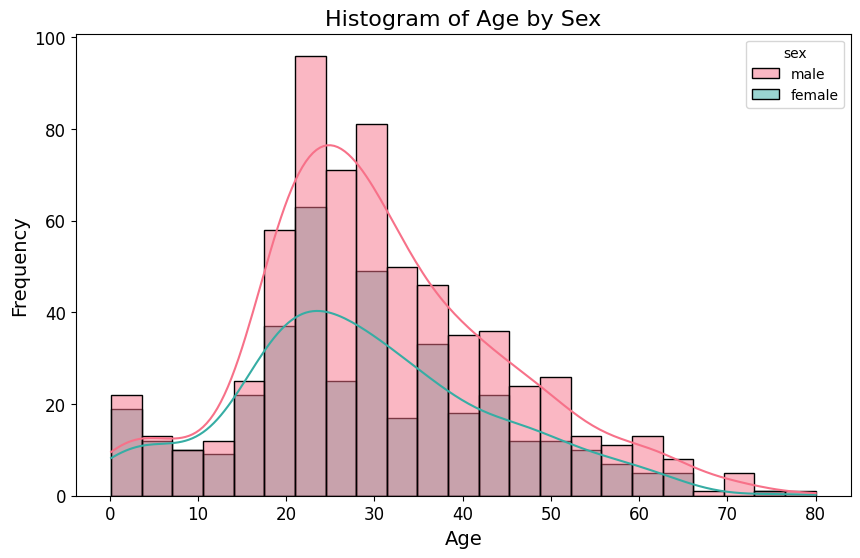

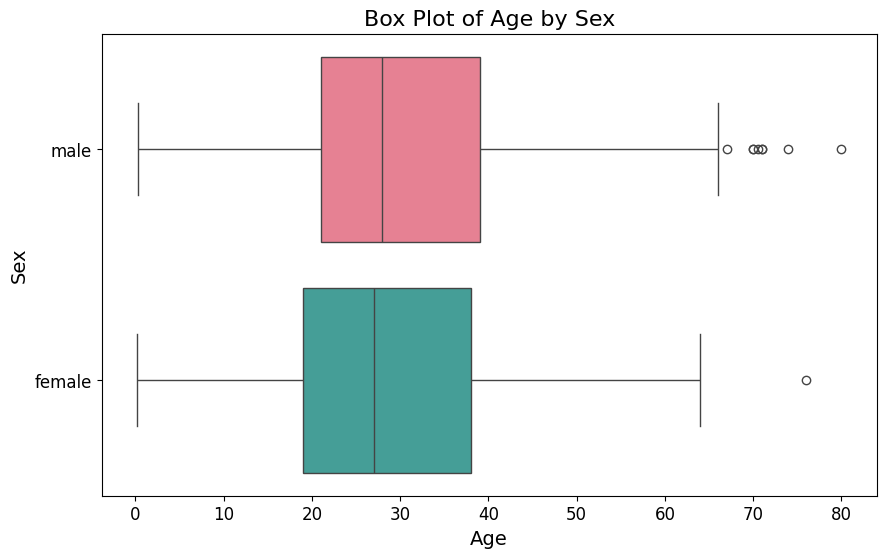

In [90]:
# bivariate analysis on age column - with categorical columns
bivariate_analysis_age_categorical(df_concat, "age", ["sex"])

- The mean age for males (30.59 years) is slightly higher than for females (28.69 years).
- The standard deviation of age is slightly lower for males (14.28 years) compared to females (14.58 years).
- ```Age``` and ```Sex``` are weakly correlated with eachother.
- We also reject the null hypothesis, as there is a significant difference in the mean ages between males and females
- Although, the relation is weak, we can consider ```Sex``` as the secondary variable of the group to fill the missing Age.

In [91]:
median_age_by_pclass_sex = df_concat.groupby(["pclass","sex"],as_index=False)["age"].median()
median_age_by_pclass_sex = median_age_by_pclass_sex.rename(columns={"age":"median_age"})
median_age_by_pclass_sex.loc[len(median_age_by_pclass_sex)] = ["Rest of the passengers", "", df_concat['age'].median()]
display(median_age_by_pclass_sex)

# filling the missing Age with median age for Pclass and Sex
age_median_by_group = df_concat.groupby(["pclass", "sex"])["age"].transform("median").reset_index(drop=True)
df_concat["age"] = df_concat["age"].fillna(age_median_by_group)

,pclass,sex,median_age
0,1,female,36.0
1,1,male,42.0
2,2,female,28.0
3,2,male,29.5
4,3,female,22.0
5,3,male,25.0
6,Rest of the passengers,,28.0


##### Cabin

In [92]:
df_concat["deck"] = df_concat["cabin"].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_concat["deck"].value_counts()

deck
M    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: count, dtype: int64

In [93]:
df_concat.groupby("pclass")["deck"].value_counts().unstack()

deck,A,B,C,D,E,F,G,M,T
pclass,,,,,,,,,
1,22.0,65.0,94.0,40.0,34.0,NaN,NaN,67.0,1.0
2,NaN,NaN,NaN,6.0,4.0,13.0,NaN,254.0,NaN
3,NaN,NaN,NaN,NaN,3.0,8.0,5.0,693.0,NaN


In [94]:
print(analyze_deck(df_concat,"T"))
print(analyze_deck(df_concat,"A"))
print(analyze_deck(df_concat,"B"))
print(analyze_deck(df_concat,"C"))
print(analyze_deck(df_concat,"D"))
print(analyze_deck(df_concat,"E"))
print(analyze_deck(df_concat,"F"))
print(analyze_deck(df_concat,"G"))

Deck: T
Median Fare: 35.5
Median Age: 45.0
Median Class: 1.0
Survival Rate: 0.0

Deck: A
Median Fare: 35.08
Median Age: 42.0
Median Class: 1.0
Survival Rate: 47.0

Deck: B
Median Fare: 82.27
Median Age: 36.0
Median Class: 1.0
Survival Rate: 74.0

Deck: C
Median Fare: 86.29
Median Age: 37.5
Median Class: 1.0
Survival Rate: 59.0

Deck: D
Median Fare: 52.55
Median Age: 42.0
Median Class: 1.0
Survival Rate: 76.0

Deck: E
Median Fare: 53.1
Median Age: 39.0
Median Class: 1.0
Survival Rate: 75.0

Deck: F
Median Fare: 13.0
Median Age: 25.0
Median Class: 2.0
Survival Rate: 62.0

Deck: G
Median Fare: 16.7
Median Age: 4.0
Median Class: 3.0
Survival Rate: 50.0



- T-deck has only one passenger, and shares many similarities with A-deck data. So, converting T-deck passenger to A-deck.
- A, B, C decks are exclusively for 1st class passengers. So, grouping them as "ABC".
- D, E shares similarities in distribution, class, and survival rate; grouping them as "DE".
- F, G share similarities in survival rates; grouping them as "FG"

In [95]:
idx = df_concat[df_concat["deck"]=="T"].index
df_concat.loc[idx,"deck"] = "A"
df_concat["deck"] = df_concat["deck"].replace(['A', 'B', 'C'], 'ABC')
df_concat["deck"] = df_concat["deck"].replace(['D', 'E'], 'DE')
df_concat["deck"] = df_concat["deck"].replace(['F', 'G'], 'FG')

df_concat["deck"].value_counts()

deck
M      1014
ABC     182
DE       87
FG       26
Name: count, dtype: int64

In [96]:
# dropping Cabin, as the missing data is nearly 80% to fill.
df_concat = df_concat.drop(columns=["cabin"])

# missing data after necessary corrections
missing_percent_concatenated = percent_missing_data(df_concat.drop("survived",axis=1),df_concat.shape[0])
if missing_percent_concatenated=="\nPercentage of Missing Values in Each Column:\n":
    print("No missing data")
else:
    print("Concatenated Data set",missing_percent_concatenated,sep="\n")

No missing data


In [97]:
# dividing the corrected data into train and test sets
df_train,df_test = df_concat[~df_concat["survived"].isna()],df_concat[df_concat["survived"].isna()].drop(columns=["survived"])

df_train.info()
print()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          891 non-null    float64
 1   embarked     891 non-null    object 
 2   fare         891 non-null    float64
 3   name         891 non-null    object 
 4   parch        891 non-null    int64  
 5   passengerid  891 non-null    int64  
 6   pclass       891 non-null    int64  
 7   sex          891 non-null    object 
 8   sibsp        891 non-null    int64  
 9   survived     891 non-null    float64
 10  ticket       891 non-null    object 
 11  deck         891 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 90.5+ KB

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 891 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          418 non-null    float64
 1   embarked     4

##### Survived

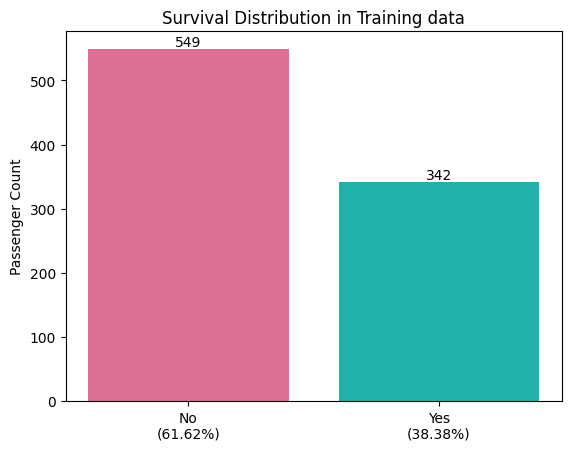

In [98]:
# analyzing the survived column in train data
survival = df_train.survived.value_counts().reset_index()
survival["survived"] = survival["survived"].replace(0,"No")
survival["survived"] = survival["survived"].replace(1,"Yes")
survival["percent"] = survival["count"].div(df_train.shape[0]).round(4).apply(lambda x:x*100)

bars = plt.bar(survival["survived"],survival["count"],color=["palevioletred","lightseagreen"])
for bar, count in zip(bars, survival["count"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), count, ha='center', va='bottom')
plt.xticks(survival["survived"], ['{}\n({:.2f}%)'.format(i,percent) for i,percent in zip(survival["survived"],survival["percent"])])
plt.ylabel('Passenger Count')
plt.title('Survival Distribution in Training data')
plt.show()

,Feature 1,Feature 2,Correlation Coefficient
0,survived,pclass,0.338
1,survived,fare,0.257


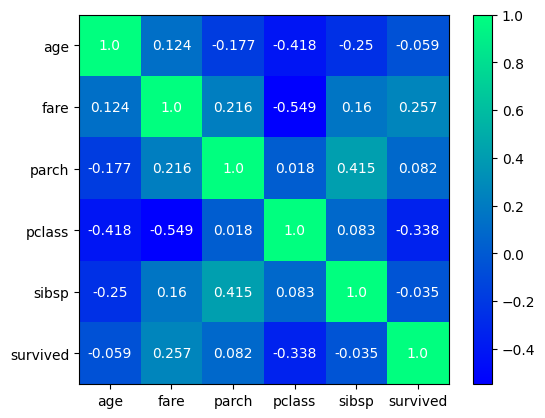

In [99]:
survived_correlation = get_correlation_table(df_train[numeric_variables],threshold=0.1,feature="survived")
display(survived_correlation)

fig,ax = plt.subplots()
features = ['age', 'fare', 'parch', 'pclass', 'sibsp', 'survived']
data = np.array(df_train[features].corr())
im = plt.imshow(data,cmap="winter")
cbar = ax.figure.colorbar(im,ax=ax)
ax.set_xticks(np.arange(data.shape[1]), labels=features)
ax.set_yticks(np.arange(data.shape[0]), labels=features)
for i in range(len(features)):
    for j in range(len(features)):
        text = ax.text(j, i, round(data[i, j],3), ha="center", va="center", color="w")
plt.show()

#### Analysis of Continuous variables on Target variable (Survived)

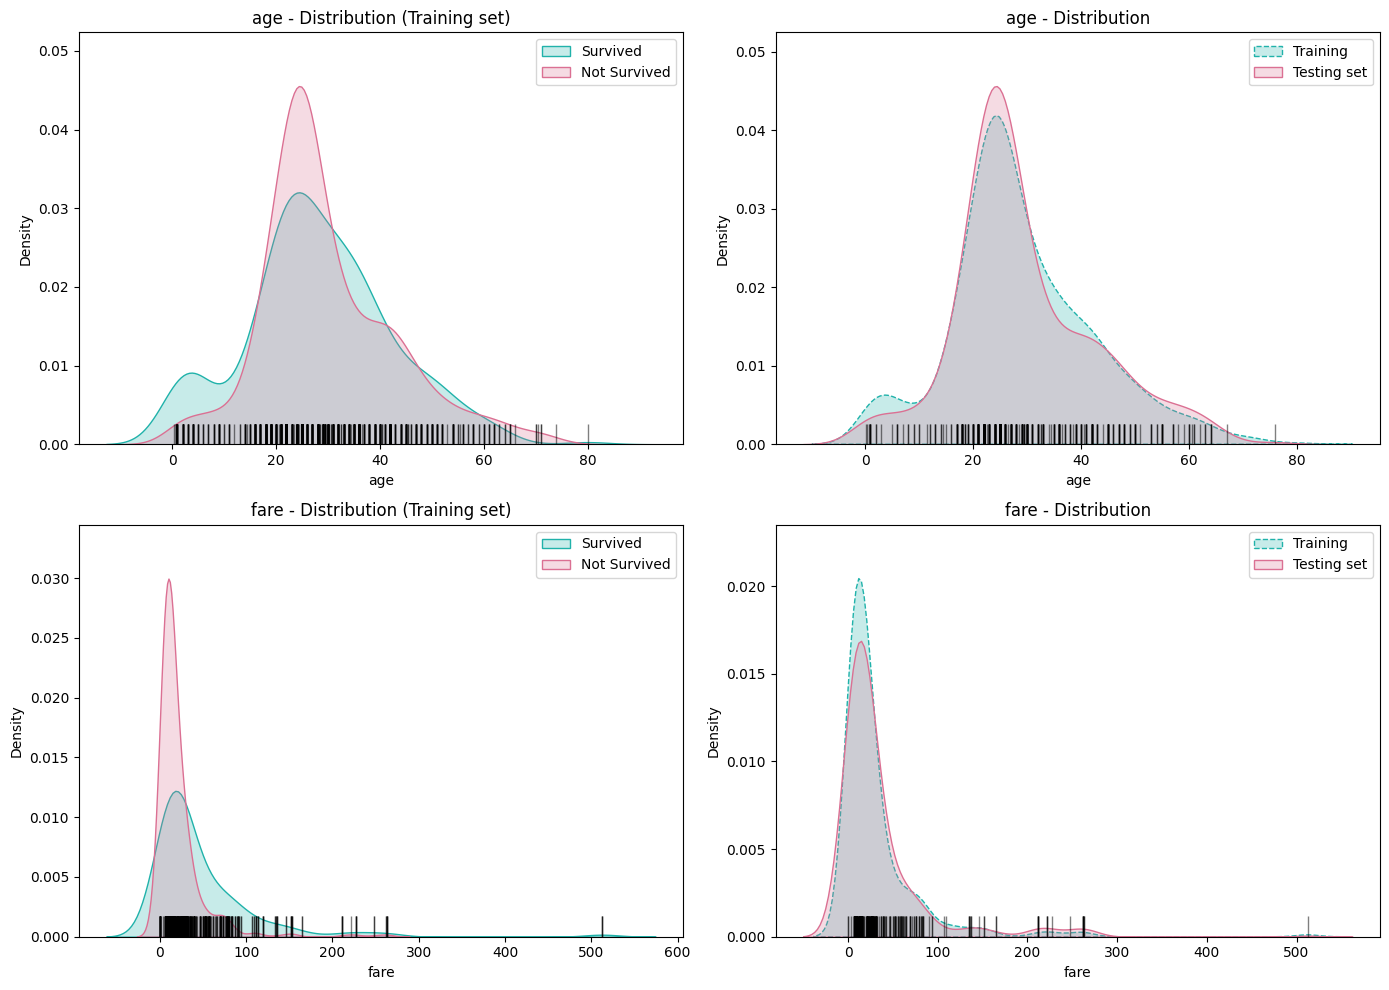

In [100]:
variables = ["age", "fare"]
datasets = [(df_train, "Training set"), (df_test, "Testing set")]

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

for i, var in enumerate(variables):
    for j, (data, data_label) in enumerate(datasets):
        if data_label == "Training set":
            sns.kdeplot(data=data[data['survived']==1][var], ax=ax[i][j], fill=True, color='lightseagreen', label='Survived')
            sns.kdeplot(data=data[data['survived']==0][var], ax=ax[i][j], fill=True, color='palevioletred', label='Not Survived')
            ax[i][j].set_title(f"{var} - Distribution ({data_label})")
        else:
            sns.kdeplot(data=df_train[var], ax=ax[i][j], fill=True, color='lightseagreen', linestyle='--', label='Training')
            sns.kdeplot(data=data[var], ax=ax[i][j], fill=True, color='palevioletred', label=f'{data_label}')
            ax[i][j].set_title(f"{var} - Distribution")
        
        sns.rugplot(data=data[var], color="black", ax=ax[i][j], height=0.05, alpha=0.5)
        
        ax[i][j].set_xlabel(var)
        handles, labels = ax[i][j].get_legend_handles_labels()
        if labels:
            ax[i][j].legend()

plt.tight_layout()
plt.show()


 - The distribution shows that ```Age``` groups falling below 20 have higher survival rate.
 - ```Fare``` distribution is positively skewed and have higher survival rates at distribution tails.
 - Both ```Age``` and ```Fare``` have fair splits in the distribution for model to learn, but testing set have smoother distribution than training set which lead the model to not be able to generalize the test set.
 - To understand the survival rates of each groups let's plot a bar chart of each groups of age and fare

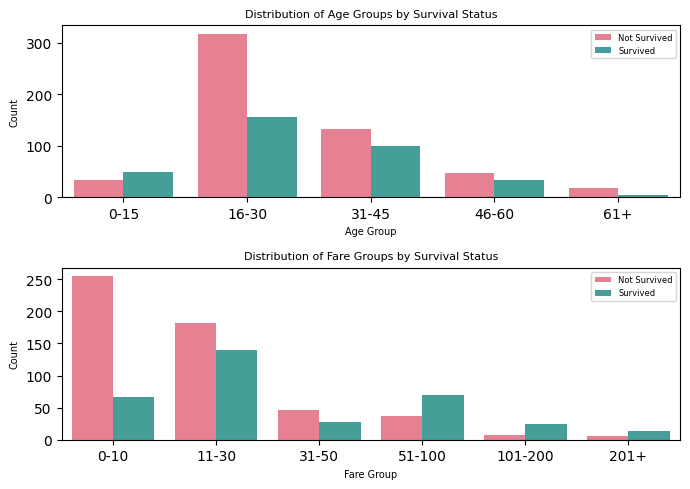

In [101]:
variables = [("age", "age_group", [0, 15, 30, 45, 60, 100], ['0-15', '16-30', '31-45', '46-60', '61+']),
             ("fare", "fare_group", [0, 10, 30, 50, 100, 200, 600], ['0-10', '11-30', '31-50', '51-100', '101-200', '201+'])]

num_subplots = len(variables)
fig, axs = plt.subplots(num_subplots, 1, figsize=(7,5))

for i, (var, var_label, bins, labels) in enumerate(variables):
    df_train[var_label] = pd.cut(df_train[var], bins=bins, labels=labels)
    sns.countplot(x=var_label, hue='survived', data=df_train, palette='husl', ax=axs[i])
    
    axs[i].set_xlabel(f'{var.capitalize()} Group', size=7)
    axs[i].set_ylabel('Count', size=7)
    axs[i].set_title(f'Distribution of {var.capitalize()} Groups by Survival Status', size=8)
    axs[i].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 6})

df_train = df_train.drop(columns=["age_group","fare_group"])
plt.tight_layout()
plt.show()


- There is high survival rate for people of age group 0-15 and high mortality rate for age group 16-30.
- Similarly high mortality rate for people travelling with lower fare and comparitively higher survival rate for people in the group paying more than $50.
- Again this could be biased. So more clarity, we will do the same analysis on complete data (to understand the density of each group).

#### Analysis of Categorical variables on Target variable (Survived)

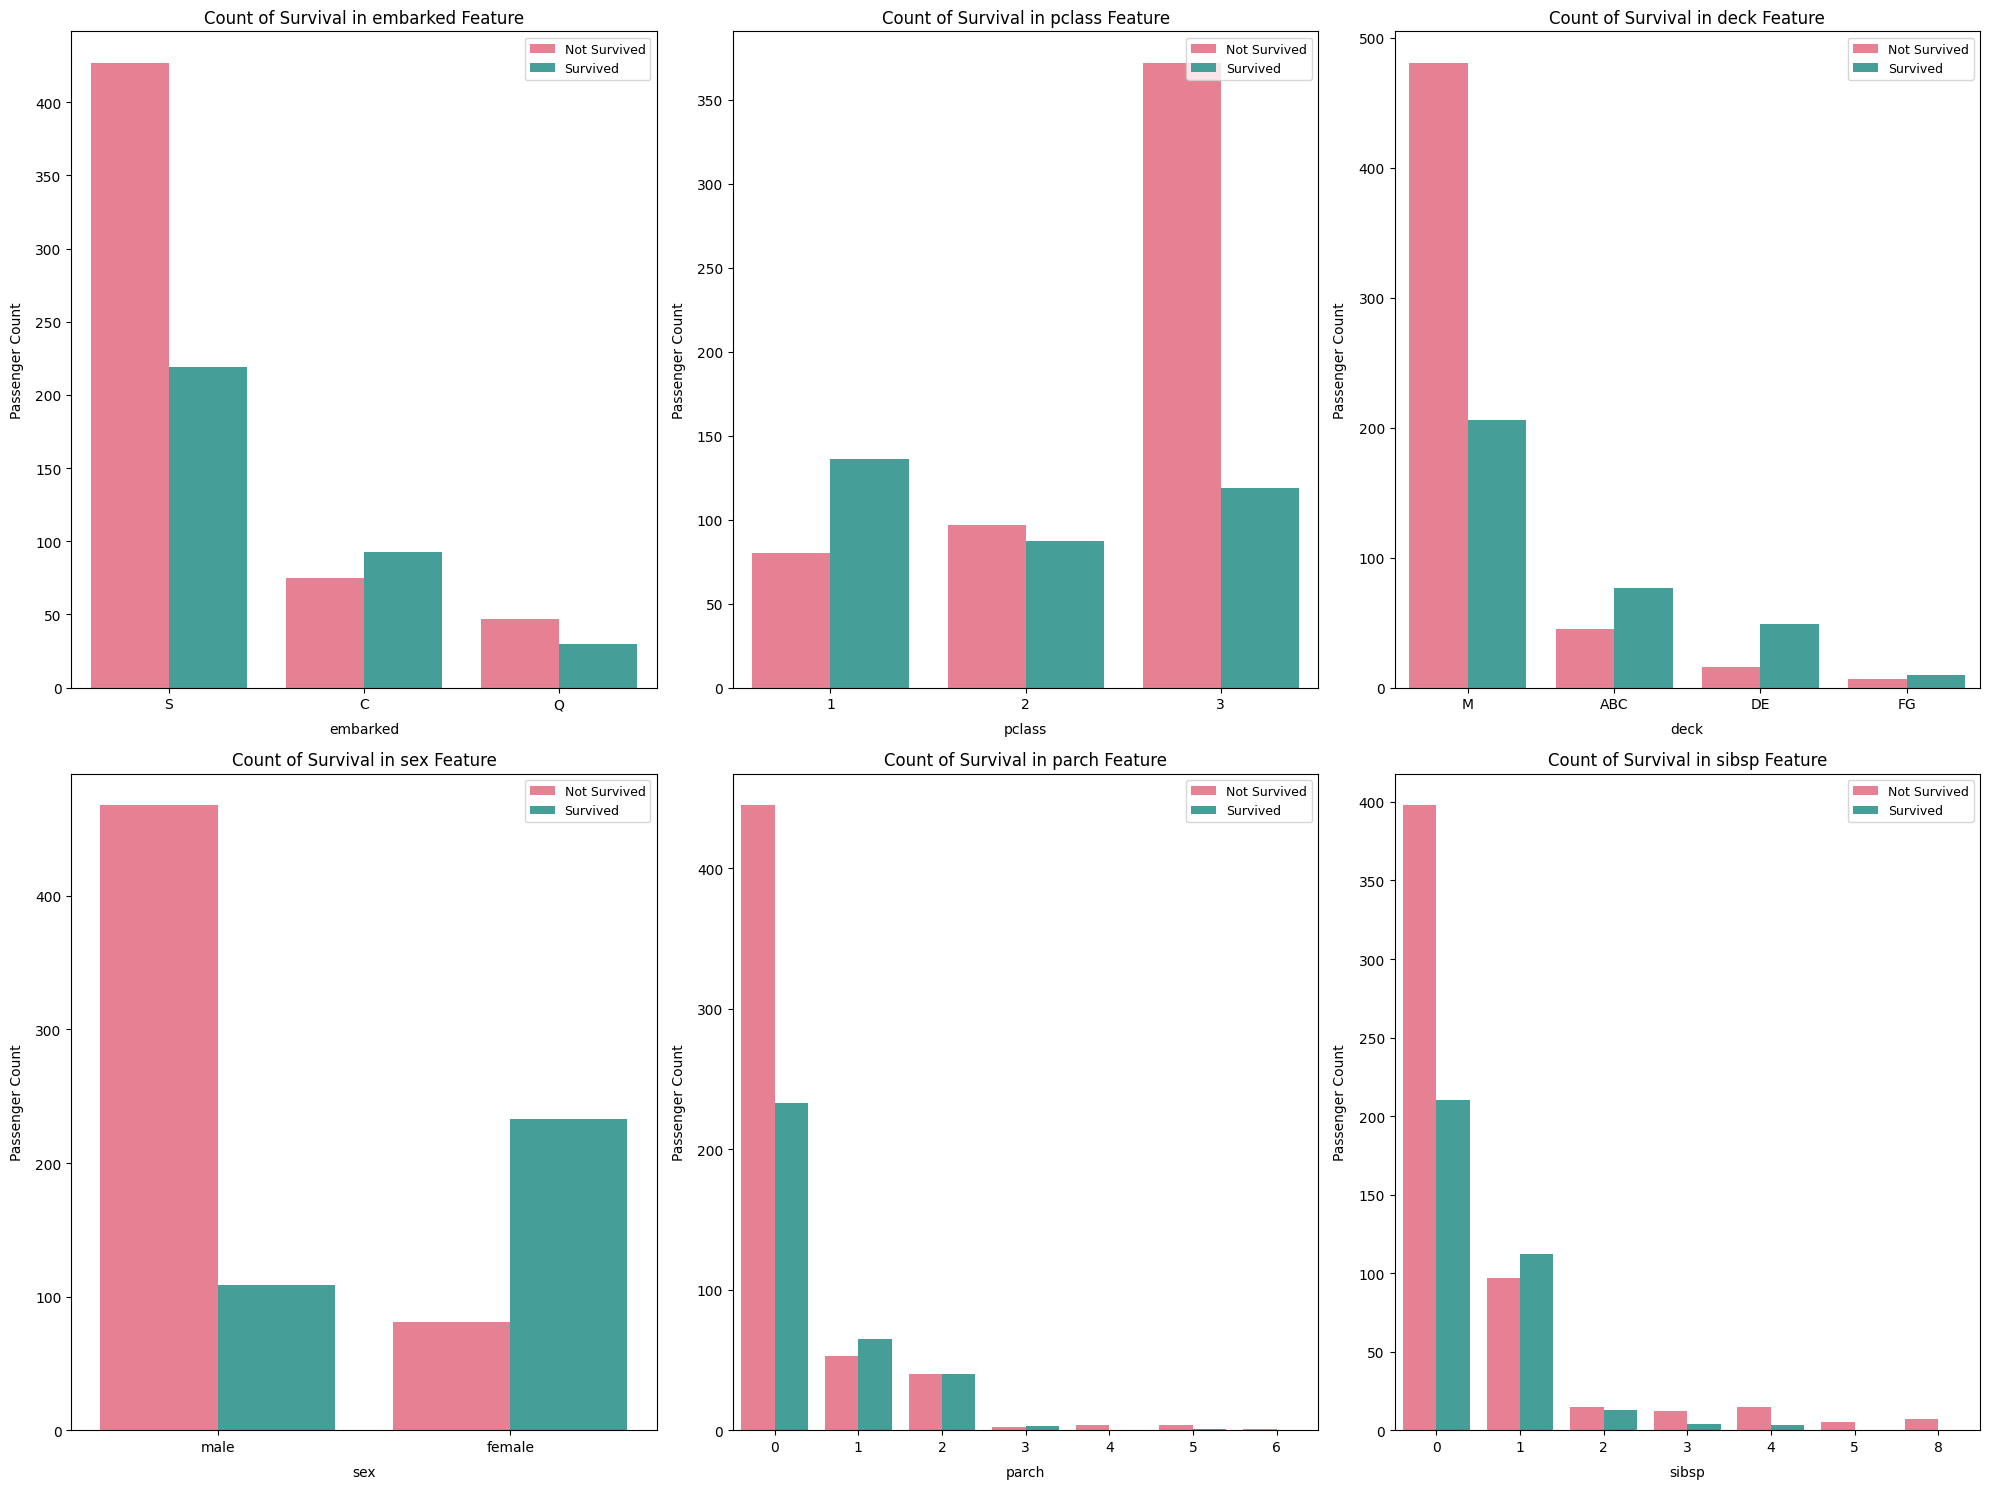

In [102]:
variables = ["embarked", "pclass", "deck", "sex", "parch", "sibsp"]
num_variables = len(variables)
num_rows = (num_variables + 2) // 3
num_cols = min(num_variables, 3)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15))

for i, var in enumerate(variables):
    row,col = divmod(i,num_cols)
    sns.countplot(x=var, hue="survived", data=df_train, palette='husl', ax=axs[row][col])

    axs[row][col].set_xlabel('{}'.format(var), size=10, labelpad=8)
    axs[row][col].set_ylabel('Passenger Count', size=10, labelpad=8)    
    axs[row][col].tick_params(axis='x', labelsize=10)
    axs[row][col].tick_params(axis='y', labelsize=10)
    
    axs[row][col].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 9})
    axs[row][col].set_title('Count of Survival in {} Feature'.format(var), size=12)

plt.tight_layout()
plt.show()

# check
# df_train.groupby("Embarked")["Pclass"].value_counts()

- Passengers boarded at Southampton (S) have high mortality rate, while more than half of passengers boarded at Cherbourg (C) have survived. When check with Pclass, we understood that, most of the passengers boarded at Southampton are from Pclass 3 and 2 (relatively high mortality); while most of the passengers boarded at Cherbourg are from 1 and 3 (also relatively high survival).
- Male passengers have high mortality rate while female passengers have high survival rate.
- When we explored the Parch and Sibsp, passengers with no family or 1 family member have relatively higher survival rates.

### Feature Engineering

In [103]:
# concatenating train and test set to feature engineer on while data set
df_concat = pd.concat([df_train,df_test])
df_concat.sample(5)

,age,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket,deck
1127,64.0,C,75.2500,"Warren, Mr. Frank Manley",0,1128,1,male,1,NaN,110813,DE
19,22.0,C,7.2250,"Masselmani, Mrs. Fatima",0,20,3,female,0,1.0,2649,M
206,32.0,S,15.8500,"Backstrom, Mr. Karl Alfred",0,207,3,male,1,0.0,3101278,M
796,49.0,S,25.9292,"Leader, Dr. Alice (Farnham)",0,797,1,female,0,1.0,17465,DE
346,40.0,S,13.0000,"Smith, Miss. Marion Elsie",0,347,2,female,0,1.0,31418,M


In [104]:
# check - to understand the deciles, this will help us decide the quantile binning size

# # Age
# df_concat["age"].describe()
# quantiles = [.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99, 0.995, 0.999, 0.9999]
# age_bins = pd.cut(df_concat["age"], bins=df_concat["age"].quantile(quantiles))
# bin_counts = age_bins.value_counts().sort_index()
# print(bin_counts)

# # Fare
# df_concat["fare"].describe()
# quantiles = [.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99, 0.995, 0.999]
# fare_bins = pd.cut(df_concat["fare"], bins=df_concat["fare"].quantile(quantiles))
# bin_counts = fare_bins.value_counts().sort_index()
# print(bin_counts)

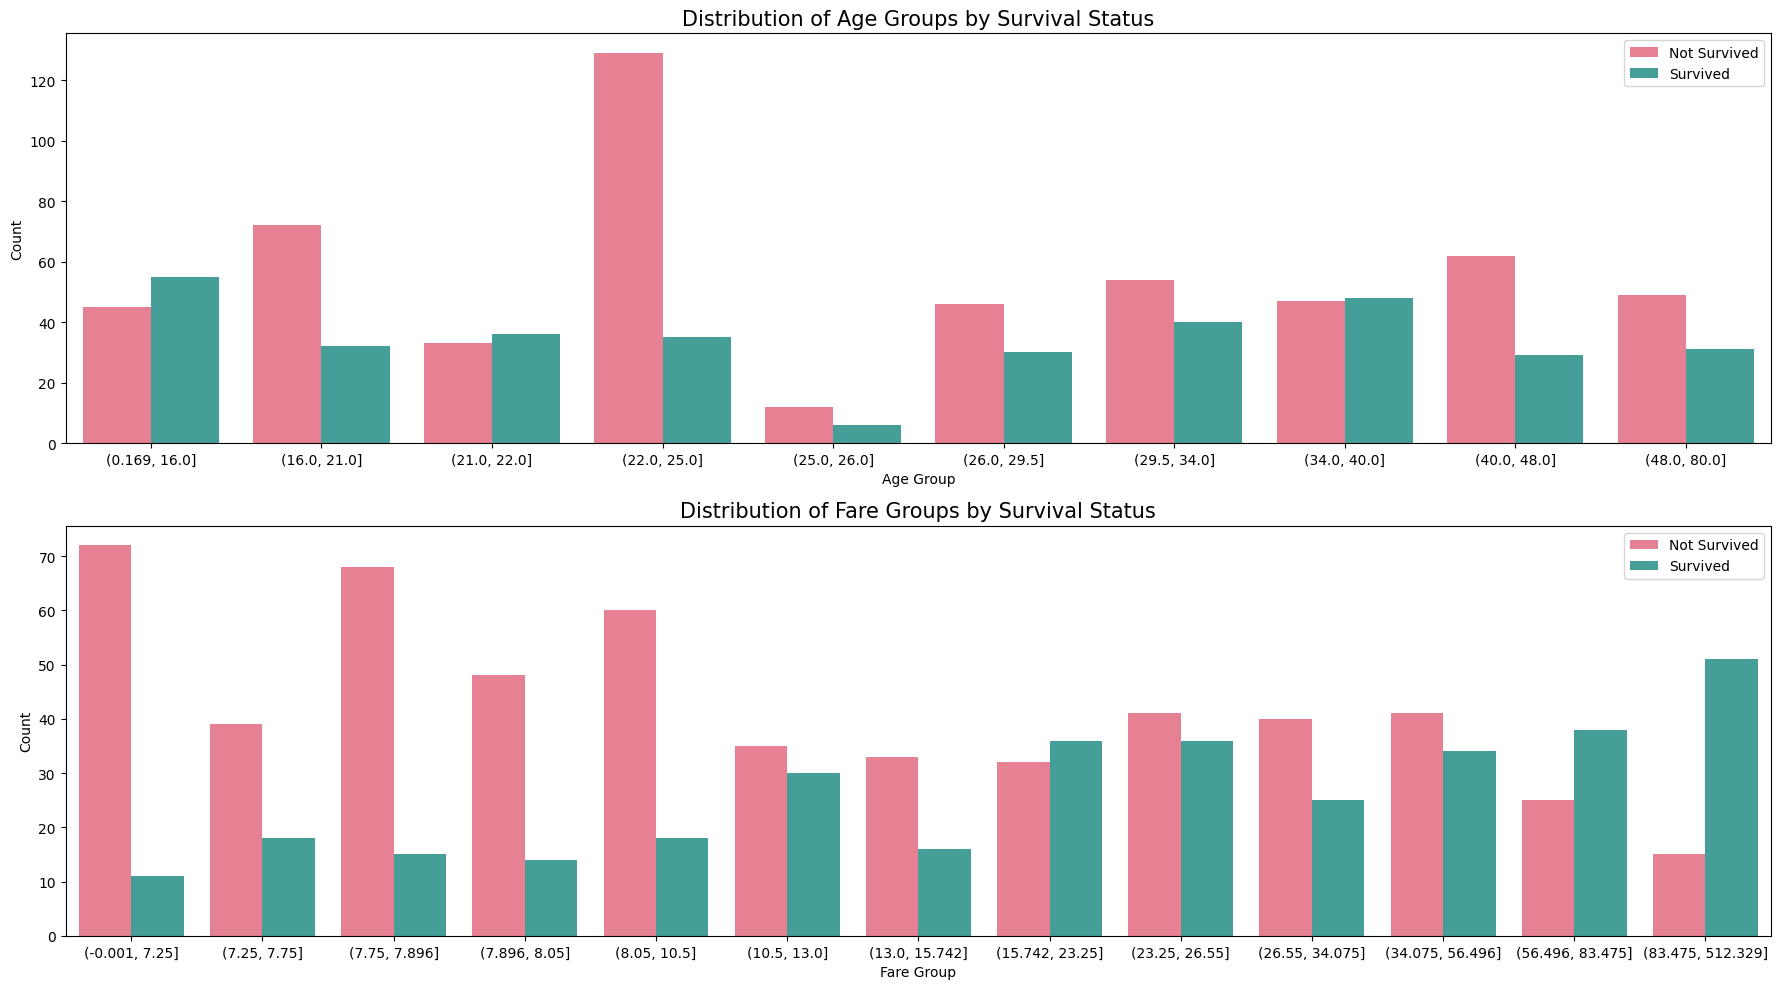

In [105]:
# continuous features - bucketing
variables = ["age","fare"]
binning_sizes = {"age":10,"fare":13}

# chose bucket size
# 10 for "Age" as the age buckets between 48-60 have less frequency, so I went ahead and grouped age 48-60 as one age buckets
# 13 for "Fare", even though the fare from 78-512 have less frequency I chose to expand the buckets to understand the
# survival distribution at the right tail of distribution and also after 500, which not present between 300-500.

num_variables = len(variables)
fig, axs = plt.subplots(num_variables, 1, figsize=(18, 10))

for i, var in enumerate(variables):
    df_concat[var] = pd.qcut(df_concat[var],binning_sizes[var])
    sns.countplot(x=var, hue="survived", data=df_concat, palette="husl", ax=axs[i])

    axs[i].set_xlabel(f"{var.capitalize()} Group", size=10)
    axs[i].set_ylabel("Count", size=10)
    axs[i].set_title(f"Distribution of {var.capitalize()} Groups by Survival Status", size=15)
    axs[i].legend(["Not Survived", "Survived"], loc="upper right", prop={"size": 10})

plt.tight_layout()
plt.show()

- Age has a normal distribution with some peaks. From the above count plot, 1st group [0.17,16.0] has highest survival rate, while 4th group [22.0,25.0] has highest mortality rate. These are the peaks in we observed in the distribution.
- Fare has positively skewed distribution with high survival rate on tail of the distribution. From the count plot, the survival rate is high for the right side groups (which was not clearly observed in distribution plot), while mortality rate is high for the left side groups with the exception of [15,23] group where the survival rate is seemingly higher.

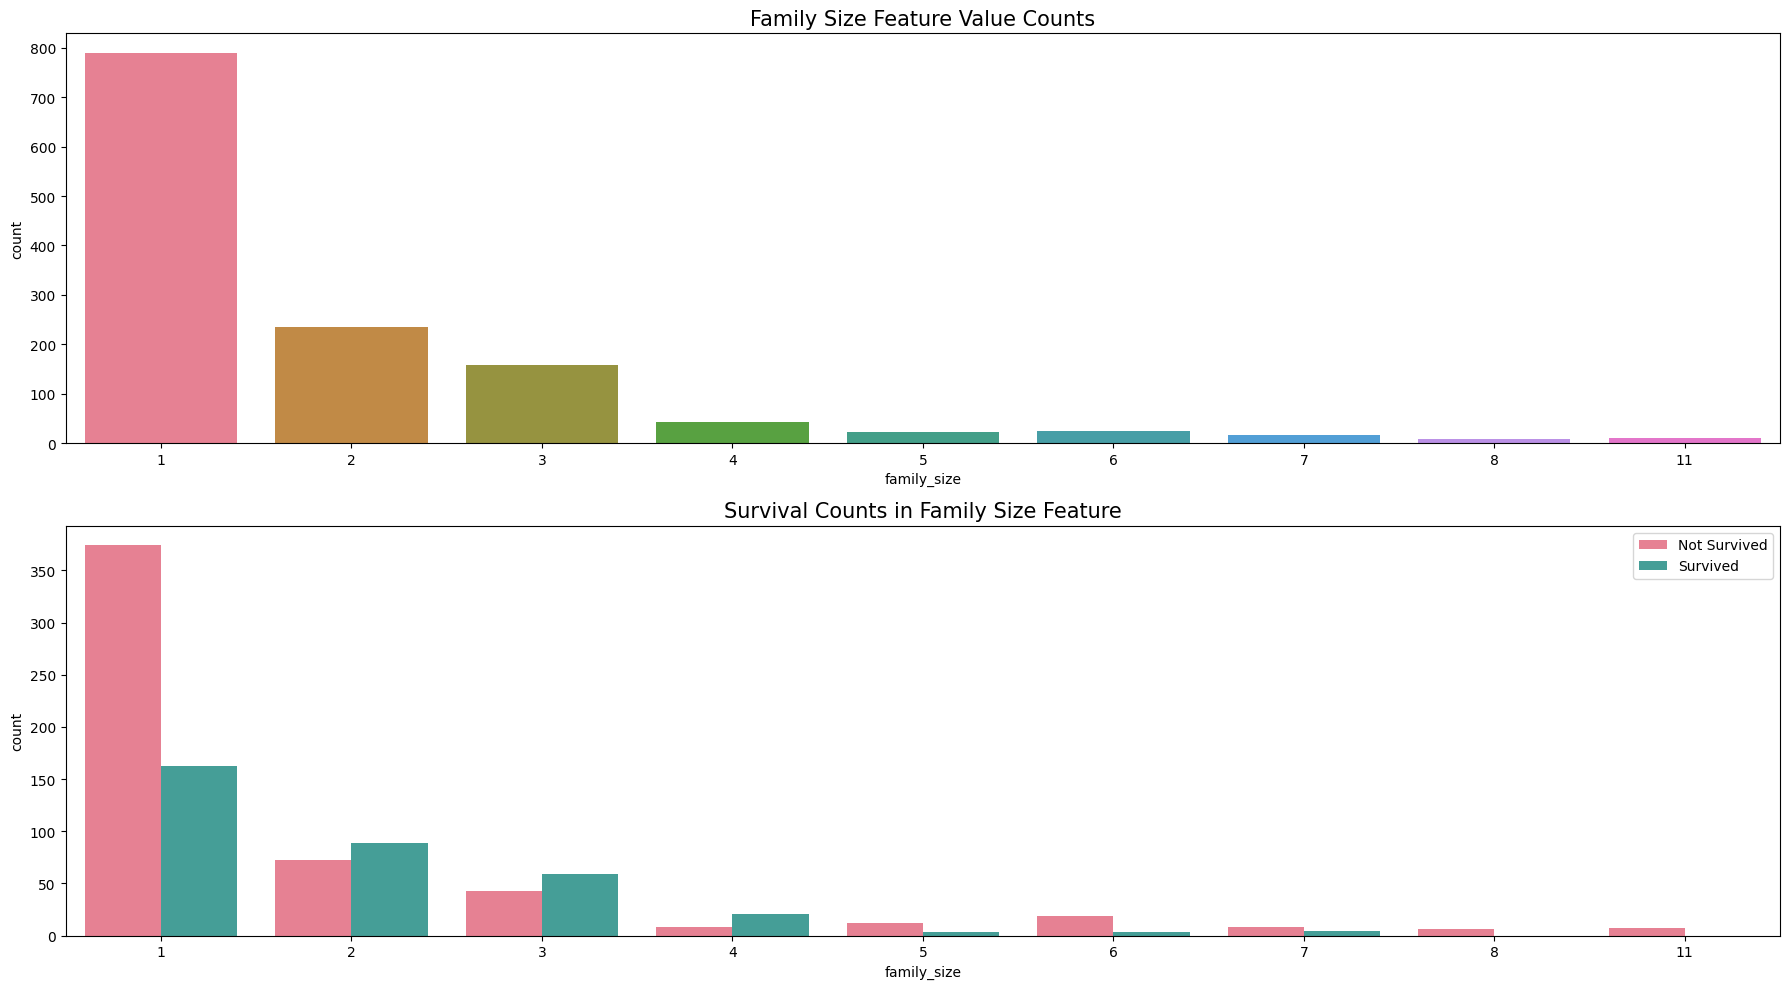

In [106]:
# categorical features - parch, sibsp - frequency encoding
df_concat["family_size"] = df_concat["parch"] + df_concat["sibsp"] + 1

fig, axs = plt.subplots(2, 1, figsize=(18, 10))

sns.countplot(x="family_size", data=df_concat, palette="husl", ax=axs[0])
axs[0].set_title(f"Family Size Feature Value Counts", size=15)

sns.countplot(x="family_size", hue="survived", data=df_concat, palette="husl", ax=axs[1])
axs[1].set_title(f"Survival Counts in Family Size Feature", size=15)
axs[1].legend(["Not Survived", "Survived"], loc="upper right", prop={"size": 10})

plt.tight_layout()
plt.show()

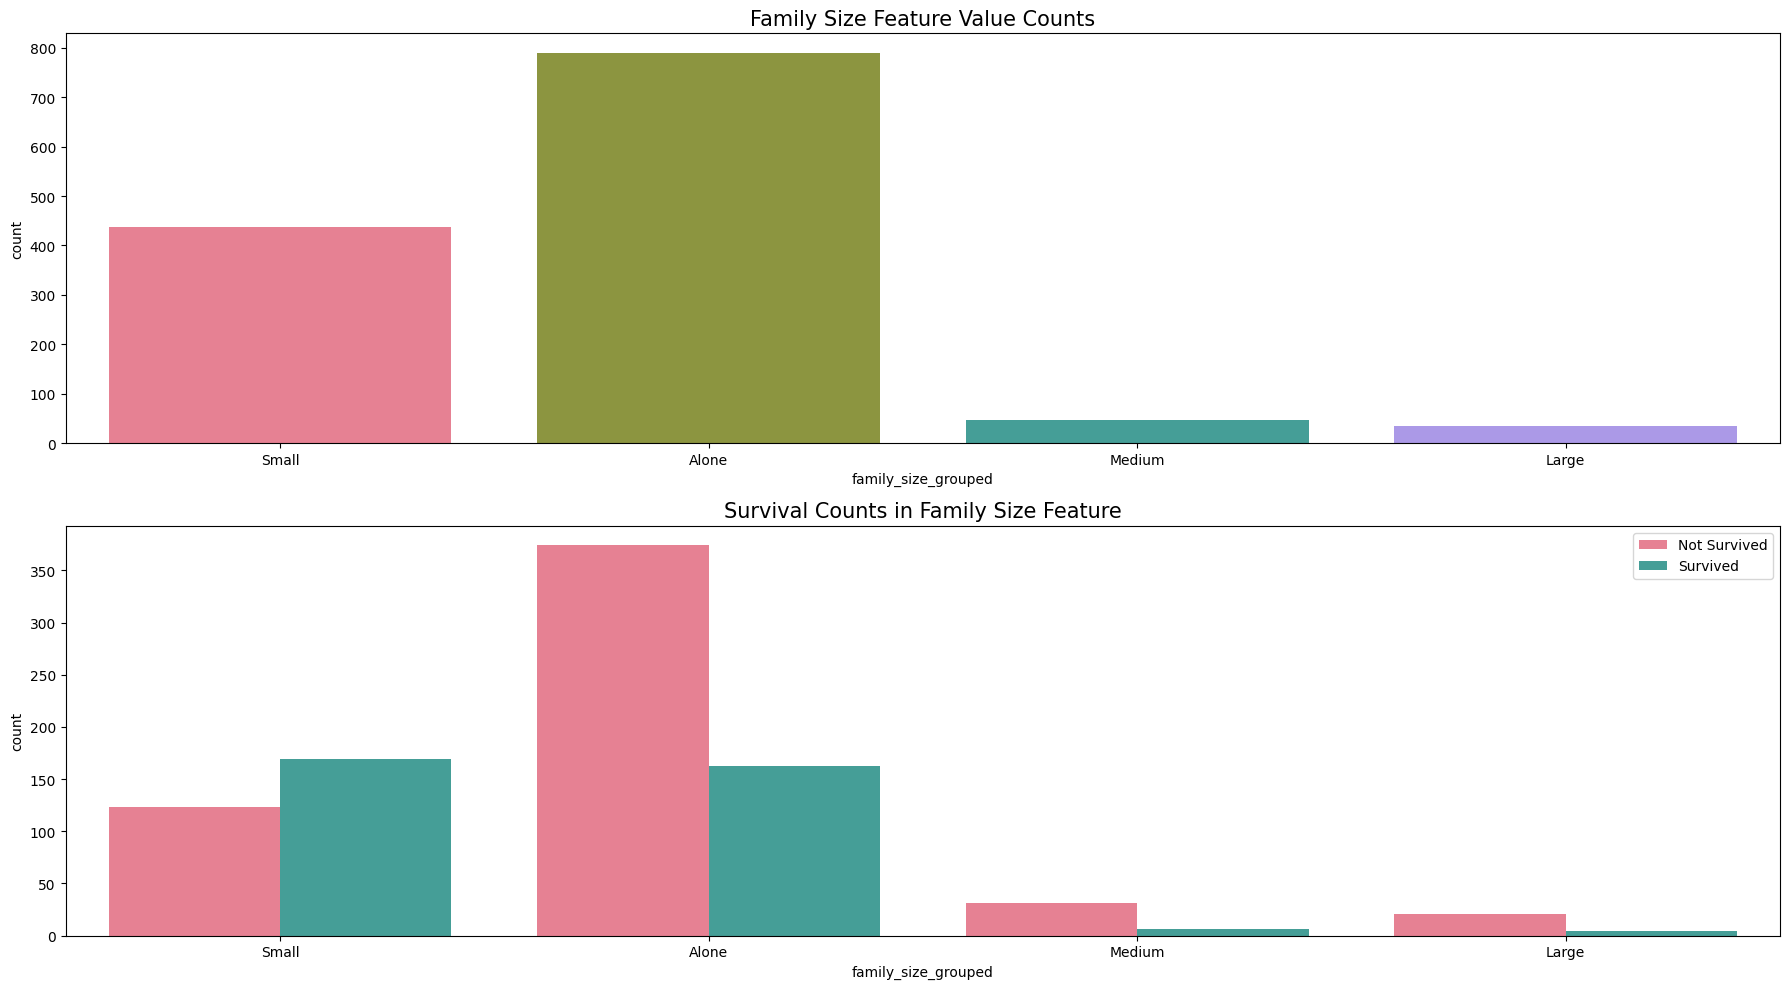

In [107]:
# family size
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_concat['family_size_grouped'] = df_concat['family_size'].map(family_map)

fig, axs = plt.subplots(2, 1, figsize=(18, 10))

sns.countplot(x="family_size_grouped", data=df_concat, palette="husl", ax=axs[0])
axs[0].set_title(f"Family Size Feature Value Counts", size=15)

sns.countplot(x="family_size_grouped", hue="survived", data=df_concat, palette="husl", ax=axs[1])
axs[1].set_title(f"Survival Counts in Family Size Feature", size=15)
axs[1].legend(["Not Survived", "Survived"], loc="upper right", prop={"size": 10})

plt.tight_layout()
plt.show()

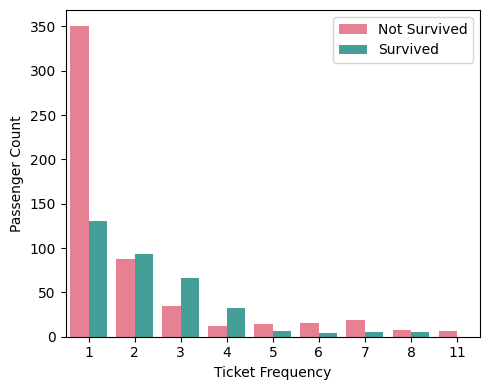

In [108]:
# ticket frequency
df_concat['ticket_frequency'] = df_concat.groupby(['ticket'])['ticket'].transform('count')

fig,ax = plt.subplots(figsize=(5,4))
sns.countplot(x='ticket_frequency',data=df_concat,hue='survived',palette='husl')
plt.xlabel('Ticket Frequency')
plt.ylabel('Passenger Count')
plt.legend(["Not Survived", "Survived"], loc="upper right", prop={"size": 10})

plt.tight_layout()
plt.show()

In [112]:
df_concat

,age,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket,deck,family_size,family_size_grouped,ticket_frequency
0,"(21.0, 22.0]",S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,M,2,Small,1
1,"(34.0, 40.0]",C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,ABC,2,Small,2
2,"(25.0, 26.0]",S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,M,1,Alone,1
3,"(34.0, 40.0]",S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,ABC,2,Small,2
4,"(34.0, 40.0]",S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,M,1,Alone,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,"(22.0, 25.0]",S,"(7.896, 8.05]","Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,M,1,Alone,1
1305,"(34.0, 40.0]",C,"(83.475, 512.329]","Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,ABC,1,Alone,3
1306,"(34.0, 40.0]",S,"(-0.001, 7.25]","Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,M,1,Alone,1
1307,"(22.0, 25.0]",S,"(7.896, 8.05]","Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,M,1,Alone,1


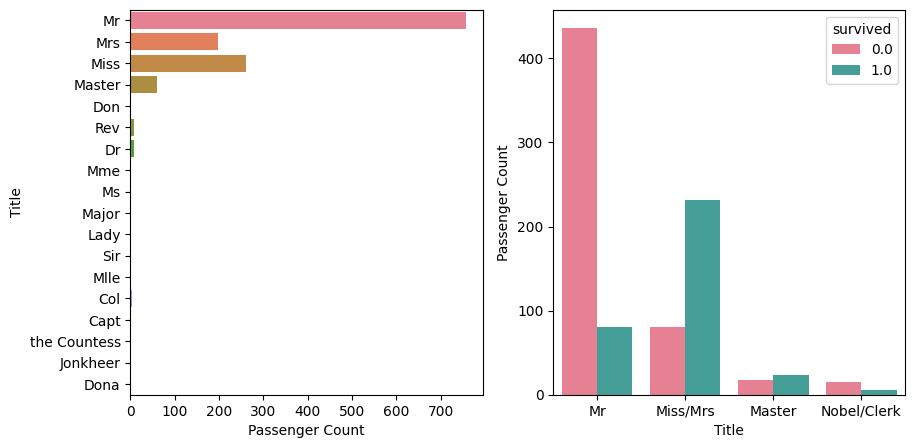

In [127]:
df_concat['title'] = df_concat['name'].str.split(', ',expand=True)[1].str.split('.',expand=True)[0]
df_concat['is_married'] = np.where(df_concat['title']=='Mrs',1,0)

fig,ax = plt.subplots(figsize=(10,5),ncols=2)
sns.countplot(y='title',data=df_concat,palette='husl',ax=ax[0])
ax[0].set_ylabel('Title')
ax[0].set_xlabel('Passenger Count')

df_concat['title'] = df_concat['title'].replace(['Miss','Mrs','Ms','Mlle','Lady','Mme','the Countess','Dona'],'Miss/Mrs')
df_concat['title'] = df_concat['title'].replace(['Rev','Dr','Col','Major','Sir','Don','Capt','Jonkheer'],'Nobel/Clerk')

sns.countplot(x='title',data=df_concat,hue='survived',palette='husl',ax=ax[1])
plt.xlabel('Title')
plt.ylabel('Passenger Count')
plt.show()

In [186]:
df_concat['family_name'] = df_concat['name'].str.split(', ',expand=True)[0]
df_train, df_test = df_concat[df_concat.survived.notnull()].reset_index(drop=True), df_concat[df_concat.survived.isnull()].drop(columns=['survived']).reset_index(drop=True)
df = pd.concat([df_train,df_test]).reset_index(drop=True)

In [187]:
non_unique_families = [x for x in df_train.family_name.unique() if x in df_test.family_name.unique()]
non_unique_tickets = [x for x in df_train.ticket.unique() if x in df_test.ticket.unique()]

df_family_survival_rate = df_train.groupby(['family_name'])[['survived','family_size']].median()
df_ticket_survival_rate = df_train.groupby(['ticket'])[['survived','ticket_frequency']].median()

family_dict, ticket_dict = {}, {}
for i in range(len(df_family_survival_rate)):
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i,1] > 1:
        family_dict[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i,1]

for i in range(len(df_ticket_survival_rate)):
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i,1] > 1:
        ticket_dict[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i,1]

In [188]:
mean_survival_rate = np.mean(df_train.survived)

train_family_survival_rate, train_family_survival_rate_na = [], []
for i in range(len(df_train)):
    if df_train['family_name'][i] in family_dict:
        train_family_survival_rate.append(family_dict[df_train['family_name'][i]])
        train_family_survival_rate_na.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_na.append(0)

df_train['family_survival_rate'] = train_family_survival_rate
df_train['family_survival_rate_na'] = train_family_survival_rate_na

test_family_survival_rate, test_family_survival_rate_na = [], []
for i in range(len(df_test)):
    if df_test['family_name'][i] in family_dict:
        test_family_survival_rate.append(family_dict[df_test['family_name'][i]])
        test_family_survival_rate_na.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_na.append(0)

df_test['family_survival_rate'] = test_family_survival_rate
df_test['family_survival_rate_na'] = test_family_survival_rate_na

train_ticket_survival_rate, train_ticket_survival_rate_na = [], []
for i in range(len(df_train)):
    if df_train['family_name'][i] in ticket_dict:
        train_ticket_survival_rate.append(ticket_dict[df_train['family_name'][i]])
        train_ticket_survival_rate_na.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_na.append(0)

df_train['ticket_survival_rate'] = train_ticket_survival_rate
df_train['ticket_survival_rate_na'] = train_ticket_survival_rate_na

test_survival_rate, test_survival_rate_na = [], []
for i in range(len(df_test)):
    if df_test['family_name'][i] in ticket_dict:
        test_survival_rate.append(ticket_dict[df_test['family_name'][i]])
        test_survival_rate_na.append(1)
    else:
        test_survival_rate.append(mean_survival_rate)
        test_survival_rate_na.append(0)

df_test['ticket_survival_rate'] = test_survival_rate
df_test['ticket_survival_rate_na'] = test_survival_rate_na

In [189]:
for x in [df_train, df_test]:
    x['survival_rate'] = (x['ticket_survival_rate'] + x['family_survival_rate']) / 2
    x['survival_rate_na'] = (x['family_survival_rate_na'] + x['ticket_survival_rate_na']) / 2    

In [195]:
# label encoding
non_numeric_features = ['embarked','sex','deck','family_size_grouped','title','age','fare']

for df in [df_train,df_test]:
    for feature in non_numeric_features:
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [207]:
df_train.sample(3)

,age,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket,deck,family_size,family_size_grouped,ticket_frequency,title,is_married,family_name,family_survival_rate,family_survival_rate_na,ticket_survival_rate,ticket_survival_rate_na,survival_rate,survival_rate_na
677,1,2,4,"Turja, Miss. Anna Sofia",0,678,3,0,0,1.0,4138,3,1,0,1,1,0,Turja,0.383838,0,0.383838,0,0.383838,0.0
558,7,2,11,"Taussig, Mrs. Emil (Tillie Mandelbaum)",1,559,1,0,1,1.0,110413,1,3,3,3,1,1,Taussig,0.383838,0,0.383838,0,0.383838,0.0
195,9,0,12,"Lurette, Miss. Elise",0,196,1,0,0,1.0,PC 17569,0,1,0,3,1,0,Lurette,0.383838,0,0.383838,0,0.383838,0.0


In [209]:
# one hot encoding
cat_features = ['pclass','sex','deck','embarked','title','family_size_grouped']
encoded_features = []

for df in [df_train,df_test]:
    for feature in cat_features:
        encoded_feature = OneHotEncoder().fit_transform(df[feature].values.reshape(-1,1)).toarray()
        n = df[feature].nunique()
        cols = [f'{feature}_{i}' for i in range(1,n+1)]
        encoded_df = pd.DataFrame(encoded_feature, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

In [211]:
df = pd.concat([df_train,df_test])
drop_cols = [
    'name','parch','passengerid','pclass','sex','sibsp','ticket','deck','family_size','family_size_grouped','title',
    'family_name','family_survival_rate','family_survival_rate_na','ticket_survival_rate','ticket_survival_rate_na',
    'survived',
]
df[list(set(df.columns) - set(drop_cols))]

,family_size_grouped_2,title_2,deck_3,ticket_frequency,title_4,embarked_1,title_3,sex_1,embarked_3,title_1,family_size_grouped_1,family_size_grouped_4,pclass_2,age,deck_4,embarked_2,survival_rate,pclass_1,sex_2,family_size_grouped_3,deck_2,is_married,fare,deck_1,survival_rate_na,embarked,pclass_3
0,0.0,0.0,0.0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2,1.0,0.0,0.383838,0.0,1.0,0.0,0.0,0,0,0.0,0.0,2,1.0
1,0.0,1.0,0.0,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,7,0.0,0.0,1.191919,1.0,0.0,0.0,0.0,1,11,1.0,0.5,0,0.0
2,0.0,1.0,0.0,1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,4,1.0,0.0,0.383838,0.0,0.0,0.0,0.0,0,3,0.0,0.0,2,1.0
3,0.0,1.0,0.0,2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,7,0.0,0.0,0.383838,1.0,0.0,0.0,0.0,1,10,1.0,0.0,2,0.0
4,0.0,0.0,0.0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,7,1.0,0.0,0.383838,0.0,1.0,0.0,0.0,0,3,0.0,0.0,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.0,0.0,0.0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3,1.0,0.0,0.383838,0.0,1.0,0.0,0.0,0,3,0.0,0.0,2,1.0
414,0.0,1.0,0.0,3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,7,0.0,0.0,0.383838,1.0,0.0,0.0,0.0,0,12,1.0,0.0,0,0.0
415,0.0,0.0,0.0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,7,1.0,0.0,0.383838,0.0,1.0,0.0,0.0,0,0,0.0,0.0,2,1.0
416,0.0,0.0,0.0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3,1.0,0.0,0.383838,0.0,1.0,0.0,0.0,0,3,0.0,0.0,2,1.0


## Model

In [216]:
drop_cols = [
    'name','parch','passengerid','pclass','sex','sibsp','ticket','deck','family_size','family_size_grouped','title',
    'family_name','family_survival_rate','family_survival_rate_na','ticket_survival_rate','ticket_survival_rate_na',
]
df_train = df_train.drop(columns=drop_cols)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    891 non-null    int32  
 1   embarked               891 non-null    int32  
 2   fare                   891 non-null    int32  
 3   survived               891 non-null    float64
 4   ticket_frequency       891 non-null    int64  
 5   is_married             891 non-null    int32  
 6   survival_rate          891 non-null    float64
 7   survival_rate_na       891 non-null    float64
 8   pclass_1               891 non-null    float64
 9   pclass_2               891 non-null    float64
 10  pclass_3               891 non-null    float64
 11  sex_1                  891 non-null    float64
 12  sex_2                  891 non-null    float64
 13  deck_1                 891 non-null    float64
 14  deck_2                 891 non-null    float64
 15  deck_3

In [219]:
# initialize X and y
X = df_train.drop('survived', axis=1)
y = df_train['survived']

# initialize the stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# for storing results
accuracies = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # train the model
    rf.fit(X_train, y_train)
    
    # predict on the test set
    y_pred = rf.predict(X_test)
    
    # calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

print(f'Average accuracy: {np.mean(accuracies):.4f}')

Average accuracy: 0.8070


In [234]:
X_train = df_train.drop('survived', axis=1)
y_train = df_train['survived']

drop_cols = [
    'name','parch','passengerid','pclass','sex','sibsp','ticket','deck','family_size','family_size_grouped','title',
    'family_name','family_survival_rate','family_survival_rate_na','ticket_survival_rate','ticket_survival_rate_na',
]
X_test = df_test.drop(columns=drop_cols)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

predictions = rf.predict(X_test)
submission = pd.DataFrame({
    'PassengerId': df_test['passengerid'],
    'Survived': predictions
})
submission.Survived = submission.Survived.astype('int64')
submission.to_csv(r'submission.csv', index=False)